# Rats

In [10]:
import jax
import jax.numpy as jnp
import blackjax as bj
from pcv.inference import run_cv_sel, cv_adaptation, one_model_inference, one_model_inference_mtune
from pcv.plots import plot_model_results, plot_fold_results
from pcv.models import rats
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az

## Model definition

Gaussian linear regression, with an outlier injected into the data

In [11]:
data = rats.get_data()
model = rats.get_model(data)

First, run model diagnostics.

In [12]:
idata, state = one_model_inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=1,
    num_chains=8,
    num_samples=100_000,
    warmup_iter=100_000
)

In [13]:
az.summary(idata,
           var_names=['mu_alpha', 'mu_beta', 'sigma_alpha', 'sigma_beta', 'sigma_y'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-0.460,0.000,-0.460,-0.460,0.000,0.000,8.0,8.0,6.925361e+15
mu_beta,0.060,0.000,0.060,0.060,0.000,0.000,8.0,8.0,8.140131e+15
sigma_alpha,0.000,0.000,0.000,0.000,0.000,0.000,11.0,23.0,1.970000e+00
sigma_beta,0.000,0.000,0.000,0.000,0.000,0.000,8.0,10.0,5.280000e+00
sigma_y,246.197,16.106,219.093,275.827,5.688,4.178,8.0,11.0,4.840000e+00


In [14]:
print(state.divergences)

[    0.     0.     0. 97609.     0.     0.     0.     0.]


/home/acooper/src/papers/parallel/code/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/acooper/src/papers/parallel/code/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


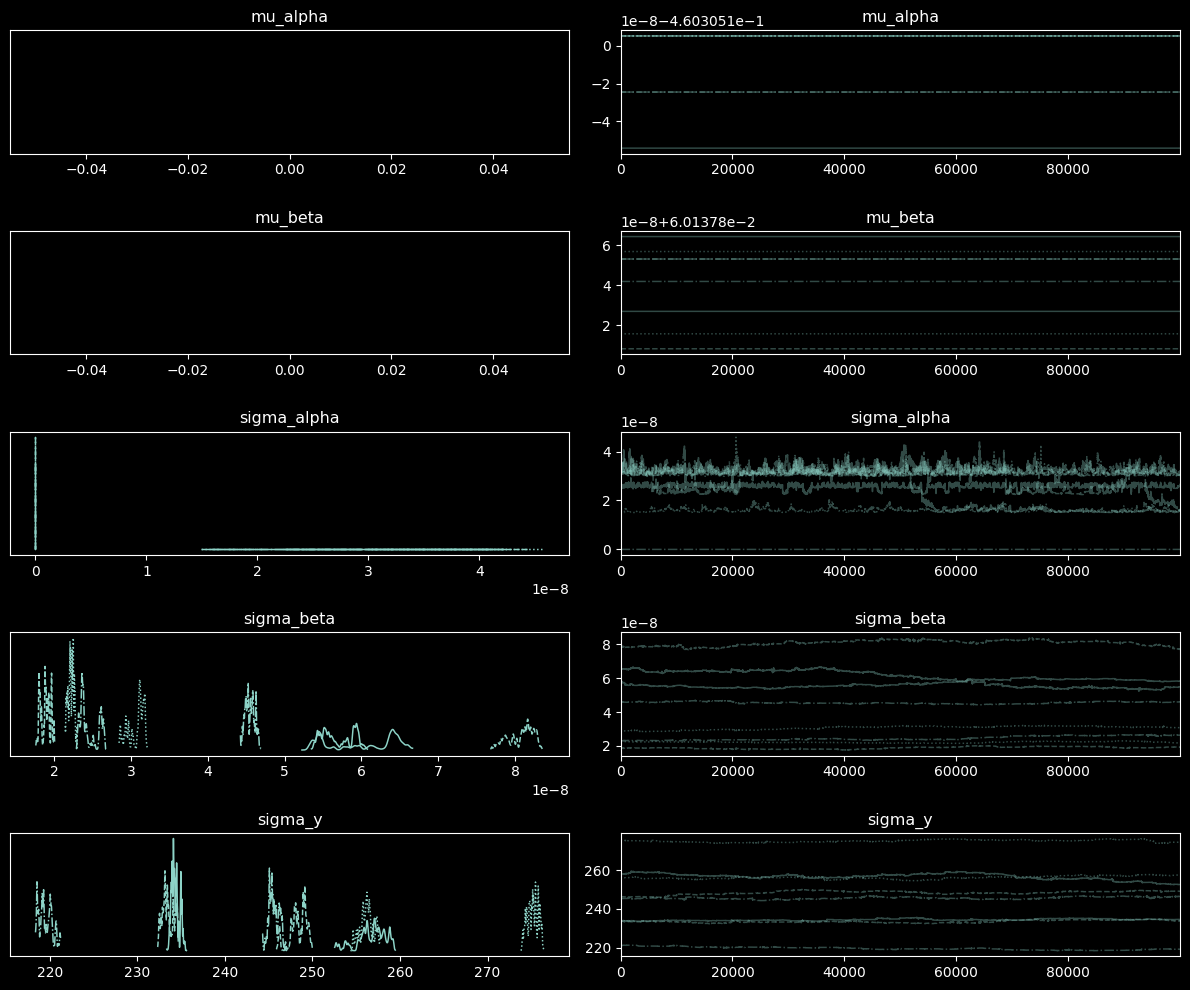

In [15]:
axes = az.plot_trace(idata, var_names=['mu_alpha', 'mu_beta', 'sigma_alpha', 'sigma_beta', 'sigma_y'])
plt.tight_layout()

## Cross-Validation


In [16]:
warmup = cv_adaptation(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    num_chains=150,
    model_warmup_iter=10_000,
    fold_warmup_iter=10_000,
    batch_size=100,
)

MEADS warmup for 2 model(s) (300 chains)...
Meads warmup done in 29.14 seconds. 
Step size: [4.8178745e-09 1.3019323e-03] Alpha: [0.00019997 0.00046384] Delta: [9.9986792e-05 2.3192167e-04]
MEADS warmup for 30 folds per model (9000 chains)...


In [ ]:
warmup.plot_dist()

In [ ]:
results = run_cv_sel(
       prng_key=jax.random.PRNGKey(0),
       model=model,
       stoprule=make_positive_negative_rule(num_folds=model.num_folds, level=0.95),
       warmup_results=warmup,
       batch_size=100,
       max_batches=50,
       ignore_stoprule=True,
       prior_only=False
)

In [ ]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

In [ ]:
plot_fold_results(results, title='Per-fold diagnostics')